# 0. Install Dependencies and Bring in Data

In [2]:
#!pip install tensorflow pandas matplotlib sklearn

In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [55]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge/train.csv/train.csv'))

In [56]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [57]:
df.iloc[3]['comment_text']

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [7]:
df[df['toxic']==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [8]:
df[df.columns[2:]].iloc[3]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 3, dtype: int64

# 1. Preprocess

In [9]:
!pip list

Package                           Version
--------------------------------- ------------
absl-py                           2.1.0
aiobotocore                       2.7.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.1.4
anaconda-navigator                2.5.2
anaconda-project                  0.11.1
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy                           5.3.4
asttokens                         2.0.5
astunparse               

In [10]:
from tensorflow.keras.layers import TextVectorization

In [11]:
TextVectorization??

Init signature:
TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
    **kwargs,
)
Source:        
@keras_export(
    "keras.layers.TextVectorization",
    "keras.layers.experimental.preprocessing.TextVectorization",
    v1=[],
)
class TextVectorization(base_preprocessing_layer.PreprocessingLayer):
    """A preprocessing layer which maps text features to integer sequences.

    This layer has basic options for managing text in a Keras model. It
    transforms a batch of strings (one example = one string) into either a list
    of token indices (one example = 1D tensor of integer token indices) or a
    dense representation (one example = 1D tensor of float values representing
    data about the example's tokens). This layer is 

In [12]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [13]:
MAX_FEATURES = 200000 # number of words in the vocab

In [14]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [15]:
vectorizer.adapt(X.values)

In [16]:
vectorized_text = vectorizer(X.values)

In [17]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [18]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [51]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [52]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [23]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 29674s 4s/step - loss: 0.0613 - val_loss: 0.0486


In [24]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

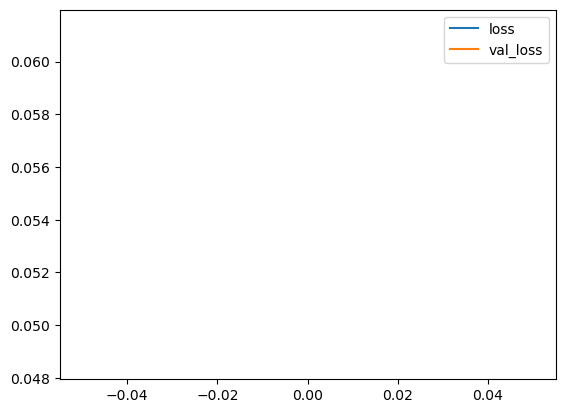

In [25]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [28]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [29]:
res = model.predict(input_text)

ValueError: in user code:

    File "C:\Users\archanaseelan\anaconda3\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\archanaseelan\anaconda3\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\archanaseelan\anaconda3\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\archanaseelan\anaconda3\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\archanaseelan\anaconda3\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\archanaseelan\anaconda3\Lib\site-packages\keras\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "bidirectional" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=False
      • mask=None


In [30]:
(res > 0.5).astype(int)

NameError: name 'res' is not defined

In [31]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [32]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 8s 8s/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [33]:
res.shape

NameError: name 'res' is not defined

# 4. Evaluate Model

In [34]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 441ms/step


In [37]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8865751028060913, Recall:0.5776559114456177, Accuracy:0.47342026233673096


# 5. Test and Gradio

In [79]:
!pip install gradio==3.50 jinja2

   ---------------------------------------- 0.0/20.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/20.3 MB 325.1 kB/s eta 0:01:03
   ---------------------------------------- 0.1/20.3 MB 655.4 kB/s eta 0:00:31
   ---------------------------------------- 0.1/20.3 MB 774.0 kB/s eta 0:00:27
   ---------------------------------------- 0.2/20.3 MB 958.4 kB/s eta 0:00:21
    --------------------------------------- 0.3/20.3 MB 1.1 MB/s eta 0:00:19
    --------------------------------------- 0.3/20.3 MB 1.0 MB/s eta 0:00:20
    --------------------------------------- 0.4/20.3 MB 1.1 MB/s eta 0:00:18
    --------------------------------------- 0.5/20.3 MB 1.2 MB/s eta 0:00:17
   - -------------------------------------- 0.6/20.3 MB 1.2 MB/s eta 0:00:17
   - -------------------------------------- 0.6/20.3 MB 1.2 MB/s eta 0:00:16
   - -------------------------------------- 0.7/20.3 MB 1.3 MB/s eta 0:00:16
   - -------------------------------------- 0.8/20.3 MB 1.3 MB/s eta 0:00:1

In [89]:
import tensorflow as tf
import gradio as gr
from gradio import Interface

In [90]:
model.save('Commenttoxicity.h5')

In [91]:
model = tf.keras.models.load_model('toxicity.h5')

In [92]:
input_str = vectorizer('hey i freaken hate you!')

In [93]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 2s 2s/step


In [94]:
res

array([[0.08167109, 0.00074272, 0.04018866, 0.00326066, 0.02187624,
        0.00648329]], dtype=float32)

In [95]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [100]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

AttributeError: type object 'Interface' has no attribute 'inputs'

In [98]:
interface.launch(share=True)

NameError: name 'interface' is not defined